# Sandbox

## Linear Regression

In [109]:
# ======= Libraries =======
import time
import numpy as np
from matplotlib import pyplot as plt
import scipy.linalg
from scipy.linalg import expm, qr
import copy

# ======= Function definitions =======

def generate_problem(p, n, lstsq=False):
    X = np.random.randn(n, p)

    # Model definition
    theta_clean = np.ones(p)
    y = X @ theta_clean + 1e-1*np.random.randn(n) # right-hand side
    theta_0 = np.random.randn(p)

    if lstsq == True:
        theta_lstsq = np.linalg.lstsq(X,y)[0]
        return X, theta_0, y, theta_lstsq
    else:
        return X, theta_0, y

def solve_local_problem(Q,R, theta_0, y_batch, h, n):
    R_it = np.linalg.inv(R.T)
    exp_m = expm(-1/n* R @ R.T*h)
    return Q @ ( exp_m @ (Q.T @ theta_0 - R_it @ y_batch )) + Q @ (R_it @ y_batch) + theta_0 - Q @ (Q.T @ theta_0)

def solve_local_problem_b_1(x, theta_0, y, h, n):
    x = x.T
    norm = x.T @ x
    return theta_0 + (1 - np.exp(-norm*h/n))*(y - x.T @ theta_0)/norm*x

def loss(X, theta, y):
    n, p = X.shape
    return 1/n*np.linalg.norm(X @ theta - y)**2

def gradient(X, theta, y):
    n, p = X.shape
    return 1/n* X.T @ (X @ theta - y)

def make_SGD_step(X_batch, theta_0, y_batch, h):
    theta = theta_0 - h*gradient(X_batch, theta_0, y_batch)
    return theta

def relative_error(theta, thetalstsq=0):
    p = len(theta)
    if np.linalg.norm(thetalstsq) != 0:
        return(np.linalg.norm(theta - thetalstsq)/np.linalg.norm(thetalstsq))
    else:
        return(np.linalg.norm(theta - np.ones(p))/np.linalg.norm(np.ones(p)))

# ======= Problem generation =======

hs = np.logspace(-2, -1, 12)
p = 2000
n = 10000
N = 200
b = 50
n_max_iter = 2000
epsilon = 0.05
n_experiments = 30

X, theta_0, y, theta_lstsq = generate_problem(p,n, lstsq=True)

Xs = np.zeros((N, b, p))
ys = np.zeros((N, b))
Qs = np.zeros((N, p, b))
Rs = np.zeros((N, b, b))

for i_batch in range(N):
    Xs[i_batch] = X[b*i_batch:b*(i_batch+1), :]
    ys[i_batch] = y[b*i_batch:b*(i_batch+1)]
    Qs[i_batch], Rs[i_batch] = qr(Xs[i_batch].T, mode='economic')

print('QR finished')

# ======= Solving problem =======

steps_spl_meta = np.zeros((n_experiments, len(hs)))
steps_sgd_meta = np.zeros((n_experiments, len(hs)))
times_spl_meta = np.zeros((n_experiments, len(hs)))
times_sgd_meta = np.zeros((n_experiments, len(hs)))

for experiment in range(n_experiments):
    print('💩 Experiment {}'.format(experiment))
    theta_0 = np.random.randn(p)
    steps_spl = []
    steps_sgd = []
    times_spl = []
    times_sgd = []
    for h in hs:
        # Splitting
        theta = copy.deepcopy(theta_0)
        n_iter = 0
        start_time = time.time()
        while relative_error(theta) > epsilon and n_iter <= n_max_iter:
            i = n_iter % N
            theta = solve_local_problem(Qs[i], Rs[i], theta, ys[i], h*N, n)
            n_iter += 1
        end_time = time.time()
        times_spl.append(end_time-start_time)
        steps_spl.append(n_iter)
        

        if n_iter > n_max_iter:
            print('Limit of iteration is reached. Relative error {:.2f}'.format(relative_error(theta)))
        else:
            print('GGWP, splitting on {} with {} iters'.format(h, n_iter))
        

        # SGD
        theta = copy.deepcopy(theta_0)
        n_iter = 0
        start_time = time.time()
        while relative_error(theta) > epsilon and n_iter <= n_max_iter:
            i = n_iter % N
            theta = make_SGD_step(Xs[i], theta, ys[i], h)
            if relative_error(theta) == float('Inf'):
                n_iter = n_max_iter
            n_iter += 1
        end_time = time.time()
        times_sgd.append(end_time-start_time)   
        if n_iter == n_max_iter+1:
            times_sgd[-1] = 10
        steps_sgd.append(n_iter)

        if n_iter > n_max_iter:
            print('Limit of iteration is reached. Relative error {:.2f}'.format(relative_error(theta)))
        else:
            print('GGWP, SGD on {} with {} iters'.format(h, n_iter))

    steps_spl_meta[experiment, :] = steps_spl
    steps_sgd_meta[experiment, :] = steps_sgd
    times_spl_meta[experiment, :] = times_spl
    times_sgd_meta[experiment, :] = times_sgd

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


QR finished
💩 Experiment 0
GGWP, splitting on 0.01 with 650 iters
GGWP, SGD on 0.01 with 526 iters
GGWP, splitting on 0.012328467394420659 with 543 iters
GGWP, SGD on 0.012328467394420659 with 422 iters
GGWP, splitting on 0.01519911082952934 with 459 iters
GGWP, SGD on 0.01519911082952934 with 345 iters
GGWP, splitting on 0.01873817422860384 with 396 iters
GGWP, SGD on 0.01873817422860384 with 294 iters
GGWP, splitting on 0.023101297000831605 with 347 iters
GGWP, SGD on 0.023101297000831605 with 270 iters
GGWP, splitting on 0.02848035868435802 with 313 iters
GGWP, SGD on 0.02848035868435802 with 276 iters
GGWP, splitting on 0.03511191734215131 with 291 iters
GGWP, SGD on 0.03511191734215131 with 339 iters
GGWP, splitting on 0.04328761281083057 with 277 iters
GGWP, SGD on 0.04328761281083057 with 682 iters
GGWP, splitting on 0.0533669923120631 with 269 iters
Limit of iteration is reached. Relative error 30351.19
GGWP, splitting on 0.06579332246575682 with 265 iters
Limit of iteration is

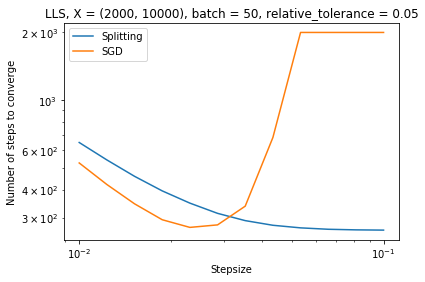

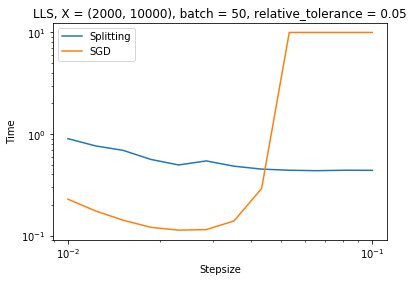

In [110]:
steps_spl = np.average(steps_spl_meta, axis = 0)  
steps_sgd = np.average(steps_sgd_meta, axis = 0) 
times_spl = np.average(times_spl_meta, axis = 0) 
times_sgd = np.average(times_sgd_meta, axis = 0) 

plt.figure(figsize=(6.0, 4.0))
plt.title('LLS, X = ({}, {}), batch = {}, relative_tolerance = {}'.format(p, n, b, epsilon))
plt.loglog(hs, steps_spl, label = 'Splitting')
plt.loglog(hs, steps_sgd, label = 'SGD')
plt.xlabel('Stepsize')
plt.ylabel('Number of steps to converge')
plt.legend()

plt.savefig('sgd_split_step_n{}.svg'.format(epsilon))
plt.show()

plt.figure(figsize=(6.0, 4.0))
plt.title('LLS, X = ({}, {}), batch = {}, relative_tolerance = {}'.format(p, n, b, epsilon))
plt.loglog(hs, times_spl, label = 'Splitting')
plt.loglog(hs, times_sgd, label = 'SGD')
plt.xlabel('Stepsize')
plt.ylabel('Time')
plt.legend()

plt.savefig('sgd_split_step_t{}.svg'.format(epsilon))
plt.show()

In [0]:
!pip install line_profiler
%load_ext line_profiler

In [0]:
theta = copy.deepcopy(theta_0)
i = 0
%lprun -f make_SGD_step make_SGD_step(Xs[i], theta, ys[i], h)

In [0]:
theta = copy.deepcopy(theta_0)
i = 0
%lprun -f solve_local_problem solve_local_problem(Qs[i], Rs[i], theta, ys[i], h, n)

## Logistic regression

In [93]:
# ======= Libraries =======

import torch
from torch.autograd import Variable
from torch.nn import functional as F
import torch.nn as nn
import torchvision.datasets as datasets
from scipy.integrate import odeint
from scipy.linalg import expm, qr
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import log_loss

# ======= Function definitions =======

def sigmoid(x):
    return np.array([1/(1 + np.exp(-x_i)) for x_i in x])

def make_splitting_step(Q, R, theta_0, y, h, n):
    h_seq = [0, h]
    z_0 = Q.T@theta_0
    def rhs(z, t):
        lin_hyp = R.T @ z
        return -1/n * R@(sigmoid(lin_hyp) - y)
    z_h = odeint(rhs, z_0, h_seq)[-1]

    theta = Q@(z_h - z_0) + theta_0
    return theta

def loss_logreg(X, theta, y):
    h_theta = [1/(1+np.exp(-theta.T @ x)) for x in X]
    y_true = y
    y_pred = h_theta
    return log_loss(y_true, y_pred)

def generate_problem_logistic_regression():
    trainset = datasets.MNIST('./mnist_data/', download=True, train=True)
    X_train = trainset.data.to(dtype=torch.float)/255
    y_train = trainset.targets
    X_train.resize_(len(X_train),  X_train[0].shape[0]*X_train[0].shape[1])
    y_train.view(-1).long()

    indicies0 = y_train == 0
    indicies1 = y_train == 1
    return X_train[indicies0 + indicies1], y_train[indicies0 + indicies1]

class LogisticRegression(torch.nn.Module):
     def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(p, 1)
     def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

def loss_moving_average(loss, window=50):
    if loss == []:
        return 1000
    else:
        return(np.average(loss[-window:]))

# ======= Problem generation =======

p = 784
n = 12665
b = 32
N = n//b
n_max_iter = 3000
n_experiments = 30

epsilon = 0.3
hs = np.logspace(-3, 3.5, 12)

X, y = generate_problem_logistic_regression()
print('Data loaded')
theta_0 = np.random.randn(p)

model = LogisticRegression()
criterion = nn.BCELoss()
print('Model loaded')

Xs = np.zeros((N, b, p))
ys = np.zeros((N, b))
Qs = np.zeros((N, p, b))
Rs = np.zeros((N, b, b))

for i_batch in range(N):
    Xs[i_batch] = X[b*i_batch:b*(i_batch+1), :]
    ys[i_batch] = y[b*i_batch:b*(i_batch+1)]
    Qs[i_batch], Rs[i_batch] = qr(Xs[i_batch].T, mode='economic')

print('QR finished')
# ======= Solving problem =======
steps_spl_meta = np.zeros((n_experiments, len(hs)))
steps_sgd_meta = np.zeros((n_experiments, len(hs)))
times_spl_meta = np.zeros((n_experiments, len(hs)))
times_sgd_meta = np.zeros((n_experiments, len(hs)))

for experiment in range(n_experiments):
    print('💩 Experiment {}'.format(experiment))
    theta_0 = np.random.randn(p)
    model = LogisticRegression()
    criterion = nn.BCELoss()
    steps_spl = []
    steps_sgd = []
    times_spl = []
    times_sgd = []
    for h in hs:
        losss_spl = []
        losss_sgd = []
        # Splitting
        theta = copy.deepcopy(theta_0)
        n_iter = 0
        start_time = time.time()
        while loss_moving_average(losss_spl) > epsilon and n_iter <= n_max_iter:
            i = n_iter % N
            X_batch = Xs[i]
            y_batch = ys[i]
            loss = loss_logreg(X_batch, theta, y_batch)
            losss_spl.append(loss)

            theta = make_splitting_step(Qs[i], Rs[i], theta, y_batch, h*N, n)
            theta = np.squeeze(theta)
            n_iter += 1
        end_time = time.time()
        times_spl.append(end_time-start_time)
        steps_spl.append(n_iter)

        if n_iter > n_max_iter:
            print('Limit of iteration is reached. Average loss {:.2f}'.format(loss_moving_average(losss_spl)))
        else:
            print('GGWP, splitting on {} with {} iters'.format(h, n_iter))
        
        # SGD
        theta = copy.deepcopy(theta_0)
        model.train()
        for parameter in model.parameters():
            parameter.data[0] = torch.from_numpy(theta)
            break
        n_iter = 0
        start_time = time.time()
        while loss_moving_average(losss_sgd) > epsilon and n_iter <= n_max_iter:
            i = n_iter % N
            X_batch = torch.from_numpy(Xs[i]).float()
            y_batch = torch.from_numpy(ys[i]).float()
            model.zero_grad()
            # Forward pass
            y_pred = model(X_batch)
            # Compute Loss
            loss = criterion(y_pred.view(-1), y_batch.view(-1))
            losss_sgd.append(loss.data)
            # Backward pass
            loss.backward()
            for parameter in model.parameters():
                parameter.data = parameter.data - h*parameter.grad.data
            if loss_moving_average(losss_sgd) == float('Inf'):
                n_iter = n_max_iter
            n_iter += 1
            # print(loss_moving_average(losss_sgd))
        end_time = time.time()
        times_sgd.append(end_time-start_time)
        if n_iter == n_max_iter+1:
            times_sgd[-1] = 1  
        steps_sgd.append(n_iter)

        if n_iter > n_max_iter:
            print('Limit of iteration is reached. Average loss {:.2f}'.format(loss_moving_average(losss_sgd)))
        else:
            print('GGWP, SGD on {} with {} iters'.format(h, n_iter))
    steps_spl_meta[experiment, :] = steps_spl
    steps_sgd_meta[experiment, :] = steps_sgd
    times_spl_meta[experiment, :] = times_spl
    times_sgd_meta[experiment, :] = times_sgd

Data loaded
Model loaded
QR finished
💩 Experiment 0
GGWP, splitting on 0.001 with 2541 iters
GGWP, SGD on 0.001 with 2539 iters
GGWP, splitting on 0.003898603702549072 with 722 iters
GGWP, SGD on 0.003898603702549072 with 722 iters
GGWP, splitting on 0.01519911082952934 with 239 iters
GGWP, SGD on 0.01519911082952934 with 222 iters
GGWP, splitting on 0.05925530975545681 with 79 iters
GGWP, SGD on 0.05925530975545681 with 78 iters
GGWP, splitting on 0.23101297000831603 with 53 iters
GGWP, SGD on 0.23101297000831603 with 52 iters
GGWP, splitting on 0.9006280202112786 with 36 iters
GGWP, SGD on 0.9006280202112786 with 28 iters
GGWP, splitting on 3.5111917342151346 with 26 iters
GGWP, SGD on 3.5111917342151346 with 21 iters
GGWP, splitting on 13.68874509537082 with 24 iters
GGWP, SGD on 13.68874509537082 with 24 iters
GGWP, splitting on 53.366992312063125 with 23 iters
GGWP, SGD on 53.366992312063125 with 21 iters
GGWP, splitting on 208.05675382171717 with 23 iters
Limit of iteration is re

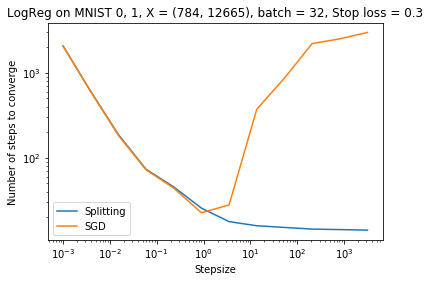

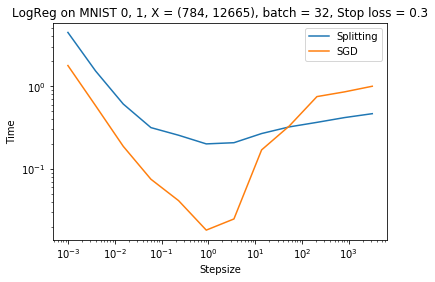

In [95]:
steps_spl = np.average(steps_spl_meta, axis = 0)  
steps_sgd = np.average(steps_sgd_meta, axis = 0) 
times_spl = np.average(times_spl_meta, axis = 0) 
times_sgd = np.average(times_sgd_meta, axis = 0) 

plt.figure(figsize=(6.0, 4.0))
plt.title('LogReg on MNIST 0, 1, X = ({}, {}), batch = {}, Stop loss = {}'.format(p, n, b, epsilon))
plt.loglog(hs, steps_spl, label = 'Splitting')
plt.loglog(hs, steps_sgd, label = 'SGD')
plt.xlabel('Stepsize')
plt.ylabel('Number of steps to converge')
plt.legend()

plt.savefig('sgd_split_logreg_times{}.svg'.format(epsilon))
plt.show()

plt.figure(figsize=(6.0, 4.0))
plt.title('LogReg on MNIST 0, 1, X = ({}, {}), batch = {}, Stop loss = {}'.format(p, n, b, epsilon))
plt.loglog(hs, times_spl, label = 'Splitting')
plt.loglog(hs, times_sgd, label = 'SGD')
plt.xlabel('Stepsize')
plt.ylabel('Time')
plt.legend()

plt.savefig('sgd_split_logreg_t{}.svg'.format(epsilon))
plt.show()

In [0]:
np.linalg.norm(theta - theta_0)

37.37806552606645

# Time measurements

In [18]:
!pip install line_profiler
%load_ext line_profiler

     |████████████████████████████████| 92kB 5.8MB/s 
  Created wheel for line-profiler: filename=line_profiler-2.1.2-cp36-cp36m-linux_x86_64.whl size=180895 sha256=97718e2b806657bf142d2e454c79cf75ba20f1abe5f8ecc910cc7a8cca382599
  Stored in directory: /root/.cache/pip/wheels/05/7d/9b/aafbe8d78dc2b2c644d2efd2f060ab3258143860142575193a
Successfully built line-profiler


In [0]:
theta = copy.deepcopy(theta_0)
i = 0
%lprun -f make_SGD_step make_SGD_step(Xs[i], theta, ys[i], h)